In [119]:
from lir_proteome_screen_pssm import environment as env
from lir_proteome_screen_pssm import pssms
import pandas as pd
import numpy as np
import logomaker as lm
import matplotlib.pyplot as plt

plt.style.use("custom_standard")
plt.style.use("custom_small")
import seaborn as sns
import lir_proteome_screen_pssm.sequence_utils as seqtools
import copy
from pathlib import Path
import re
import umap
from sklearn.preprocessing import OneHotEncoder
import lir_proteome_screen_pssm.data_loaders as dl
import lir_proteome_screen_pssm.stats as stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1. load test set
2. make score functions - aucPRC, roc_auc
3. set up parameters to screen
4. build dataframe of results

# load test set

In [120]:
df = dl.TEST_SETS.lir_central_augmented.copy()
df = df.drop_duplicates(subset=["sequence"])

screening pssm parameters:
- foreground set
    - all binders
    - all binders weighted
    - binders with > 2.4 z-score
- background set
    - input library
    - proteome
    - nonbinders
- low count cutoff
- pseudocounts

ilir parameters:
- foreground set
    - ilir
- background set
    - ilir
    - proteome
- low count cutoff
- pseudocounts

# set up grid search

In [121]:
psi_blast_pssm_dict = {
    "screen_all_binders-psiblast": pd.read_csv(
        env.DATA_DIR / "processed" / "pssms" / "screen-all_binders_psiblast_pssm.csv"
    ),
    "screen_z_score_above_2_4-psiblast": pd.read_csv(
        env.DATA_DIR
        / "processed"
        / "pssms"
        / "screen-z_score_above_2_4_psiblast_pssm.csv"
    ),
    "ilir_binders-psiblast": pd.read_csv(
        env.DATA_DIR / "processed" / "pssms" / "fg-ilir_bg-proteome_psiblast.csv"
    ),
}

In [122]:
data_origin_map = {
    "screen_all_binders": "screen",
    "screen_all_binders_weighted": "screen",
    "screen_z_score_above_2_4": "screen",
    "ilir_binders": "ilir",
    "screen_all_binders-psiblast": "psiblast",
    "screen_z_score_above_2_4-psiblast": "psiblast",
    "ilir_binders-psiblast": "psiblast",
}

In [123]:
# fg_sets = [i for i in dl.COUNT_MATRICES.__dict__.keys() if 'file' not in i]
# bg_sets = list(dl.BGFREQS.__dict__.keys())

fg_sets = [
    "screen_all_binders",
    "screen_all_binders_weighted",
    "screen_z_score_above_2_4",
]
bg_sets = ["proteome", "input_library", "nonbinders_undef_pos"]
pseudo_counts = [0, 0.1, 1, 10]
low_count_cutoffs = [0, 2, 5, 10]
parameter_combinations = []
for fg_set in fg_sets:
    for bg_set in bg_sets:
        for pseudo_count in pseudo_counts:
            if pseudo_count != 0:
                parameter_combinations.append((fg_set, bg_set, pseudo_count, 0))
                continue
            for low_count_cutoff in low_count_cutoffs:
                parameter_combinations.append(
                    (fg_set, bg_set, pseudo_count, low_count_cutoff)
                )
fg_sets = ["ilir_binders"]
bg_sets = ["proteome", "ilir_bg"]
pseudo_counts = [0, 0.1, 1, 10]
low_count_cutoffs = [0, 2, 5]
for fg_set in fg_sets:
    for bg_set in bg_sets:
        for pseudo_count in pseudo_counts:
            if pseudo_count != 0:
                parameter_combinations.append((fg_set, bg_set, pseudo_count, 0))
                continue
            for low_count_cutoff in low_count_cutoffs:
                parameter_combinations.append(
                    (fg_set, bg_set, pseudo_count, low_count_cutoff)
                )
parameter_combinations.append(("screen_all_binders-psiblast", "proteome", 0, 0))
parameter_combinations.append(("screen_z_score_above_2_4-psiblast", "proteome", 0, 0))
parameter_combinations.append(("ilir_binders-psiblast", "proteome", 0, 0))
print(len(parameter_combinations))

78


# score test set

In [124]:
def fractional_score(seq, pssm):
    max_score = pssm.max(axis=1).sum()
    min_score = pssm.min(axis=1).sum()
    score_mag = max_score - min_score
    score = pssms.PSSM_score_sequence(seq, pssm)
    return (score - min_score) / score_mag

In [125]:
auc_results = []
scores = []
pssms_dict = {}

for p in parameter_combinations:
    fg_set, bg_set, pseudo_count, low_count_cutoff = p
    if fg_set in psi_blast_pssm_dict:
        pssm = psi_blast_pssm_dict[fg_set]
    else:
        fg = getattr(dl.COUNT_MATRICES, fg_set)
        bg = getattr(dl.BGFREQS, bg_set)
        pssm = pssms.make_pssm(
            fg, bg, min_count=low_count_cutoff, pseudocount=pseudo_count, plot=False
        )
    temp_df = df.copy()
    temp_df["pssm_score"] = temp_df["sequence"].apply(
        pssms.PSSM_score_sequence, PSSM=pssm
    )
    temp_df["pssm_score_fraction"] = temp_df["sequence"].apply(
        fractional_score, pssm=pssm
    )
    temp_df["pssm_score_normalized"] = (temp_df["pssm_score"] - temp_df["pssm_score"].min())/(temp_df["pssm_score"].max() - temp_df["pssm_score"].min())
    _, _, _, auprc = stats.df_2_precision_recall_curve(
        temp_df, "true label", "pssm_score"
    )
    auroc = stats.df_2_roc_auc(temp_df, "true label", "pssm_score")
    # Store results for summary
    auc_results.append(
        {
            "foreground": fg_set,
            "background": bg_set,
            "low_count_mask": low_count_cutoff,
            "pseudocount": pseudo_count,
            "auROC": auroc,
            "auPRC": auprc,
        }
    )

    all_scored_df = temp_df[["sequence", "pssm_score", "pssm_score_fraction", "pssm_score_normalized"]].copy()
    all_scored_df["foreground"] = fg_set
    all_scored_df["background"] = bg_set
    all_scored_df["low_count_mask"] = low_count_cutoff
    all_scored_df["pseudocount"] = pseudo_count
    scores.append(all_scored_df)
    pssms_dict['-'.join([fg_set, bg_set, str(low_count_cutoff), str(float(pseudo_count))])] = pssm

all_scored_df = scores[0]
for s in scores[1:]:
    all_scored_df = pd.concat([all_scored_df, s], ignore_index=True)

auc_results_df = pd.DataFrame(auc_results)

all_scored_df["data_source"] = all_scored_df["foreground"].map(data_origin_map)
all_scored_df.to_csv("./all_scores.csv", index=False)
auc_results_df["data_source"] = auc_results_df["foreground"].map(data_origin_map)
auc_results_df.to_csv("./results.csv", index=False)

In [126]:
print(
    "Best parameters (auROC):\n", auc_results_df.loc[auc_results_df["auROC"].idxmax()]
)
print("++++++++++++++++++++++++++++++++++++++")
print(
    "Best parameters (auPRC):\n", auc_results_df.loc[auc_results_df["auPRC"].idxmax()]
)

Best parameters (auROC):
 foreground        ilir_binders
background            proteome
low_count_mask               0
pseudocount                0.0
auROC                 0.702419
auPRC                 0.750307
data_source               ilir
Name: 63, dtype: object
++++++++++++++++++++++++++++++++++++++
Best parameters (auPRC):
 foreground        ilir_binders
background            proteome
low_count_mask               5
pseudocount                0.0
auROC                 0.699593
auPRC                 0.783079
data_source               ilir
Name: 65, dtype: object


In [127]:
psiblast_scores = all_scored_df[all_scored_df["data_source"] == "psiblast"].copy()
other_scores = all_scored_df[all_scored_df["data_source"] != "psiblast"].copy()

psiblast_auc_results = auc_results_df[
    auc_results_df["data_source"] == "psiblast"
].copy()
other_auc_results_df = auc_results_df[
    auc_results_df["data_source"] != "psiblast"
].copy()

In [128]:
other_scores

,sequence,pssm_score,pssm_score_fraction,pssm_score_normalized,foreground,background,low_count_mask,pseudocount,data_source
0,PTSYSRL,4.656750,0.625044,0.497613,screen_all_binders,proteome,0,0.0,screen
1,EEDFVKV,7.796665,0.757645,0.765178,screen_all_binders,proteome,0,0.0,screen
2,EDEWEVI,10.365098,0.866111,0.984045,screen_all_binders,proteome,0,0.0,screen
3,NLDWSWL,6.193684,0.689950,0.628581,screen_all_binders,proteome,0,0.0,screen
4,KEIWHLL,7.750063,0.755677,0.761207,screen_all_binders,proteome,0,0.0,screen
...,...,...,...,...,...,...,...,...,...
10120,FGSWQEY,3.249158,0.479135,0.566061,ilir_binders,ilir_bg,0,10.0,ilir
10121,EDQWINI,5.368824,0.578754,0.815655,ilir_binders,ilir_bg,0,10.0,ilir
10122,KVYFLPI,0.869961,0.367319,0.285907,ilir_binders,ilir_bg,0,10.0,ilir
10123,RPQFFIV,1.612203,0.402203,0.373307,ilir_binders,ilir_bg,0,10.0,ilir


# explore grid search performance results

In [129]:
for i in auc_results_df["data_source"].unique():
    print(f"        best results for {i}")
    print("$++++++++++++++++++++++++++++++++++++++$")
    temp_df = auc_results_df[auc_results_df["data_source"] == i].copy()
    print("Best parameters (auROC):\n", temp_df.loc[temp_df["auROC"].idxmax()])
    print("--------------------------------------------")
    print("Best parameters (auPRC):\n", temp_df.loc[temp_df["auPRC"].idxmax()])
    print("\n")

        best results for screen
$++++++++++++++++++++++++++++++++++++++$
Best parameters (auROC):
 foreground        screen_all_binders_weighted
background                           proteome
low_count_mask                              0
pseudocount                              10.0
auROC                                0.687839
auPRC                                0.746145
data_source                            screen
Name: 27, dtype: object
--------------------------------------------
Best parameters (auPRC):
 foreground        screen_z_score_above_2_4
background                        proteome
low_count_mask                           2
pseudocount                            0.0
auROC                              0.68264
auPRC                             0.756929
data_source                         screen
Name: 43, dtype: object


        best results for ilir
$++++++++++++++++++++++++++++++++++++++$
Best parameters (auROC):
 foreground        ilir_binders
background            proteom

## distributions of performance metrics - ilir vs screen

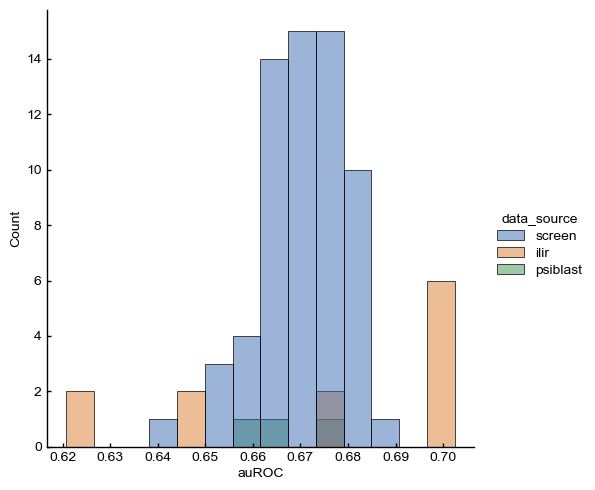

In [130]:
sns.displot(
    data=auc_results_df,
    x="auROC",
    hue="data_source",
    common_norm=False,
)

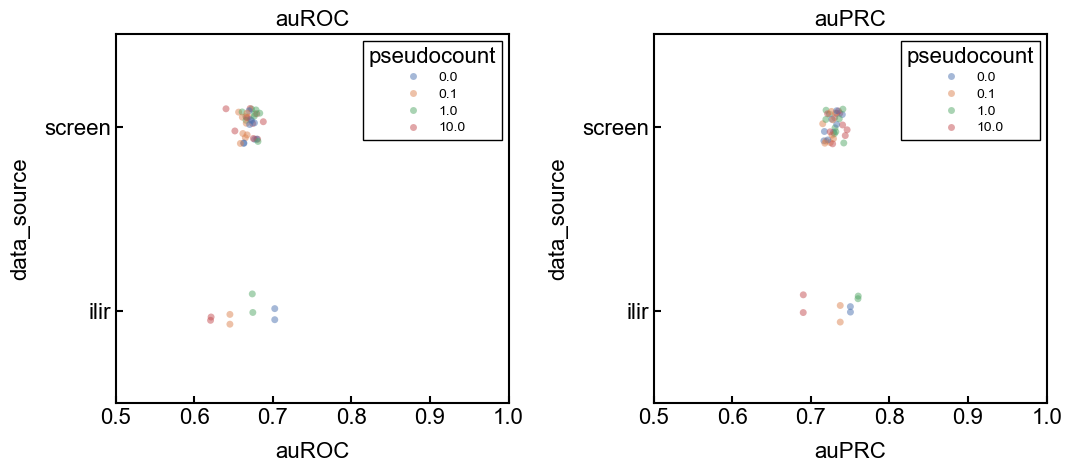

In [ ]:
plt.style.use("custom_standard")
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(ncols=2, figsize=(11, 5))
sns.stripplot(
    data=auc_results_df[auc_results_df["low_count_mask"] == 0],
    x="auROC",
    y="data_source",
    hue="pseudocount",
    alpha=0.5,
    ax=axes[0],
    palette="deep",
)
sns.stripplot(
    data=auc_results_df[auc_results_df["low_count_mask"] == 0],
    x="auPRC",
    y="data_source",
    hue="pseudocount",
    alpha=0.5,
    ax=axes[1],
    palette="deep",
)
axes[0].set_title("auROC")
axes[1].set_title("auPRC")
for ax in axes:
    ax.set_xlim(0.5, 1)
plt.tight_layout()

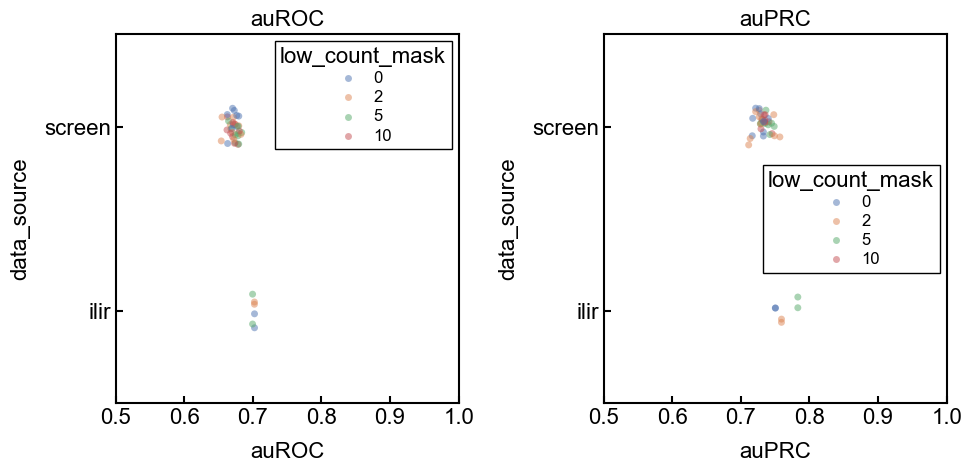

In [132]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
sns.stripplot(
    data=other_auc_results_df[other_auc_results_df["pseudocount"] == 0],
    x="auROC",
    y="data_source",
    hue="low_count_mask",
    alpha=0.5,
    ax=axes[0],
    palette="deep",
)
sns.stripplot(
    data=other_auc_results_df[other_auc_results_df["pseudocount"] == 0],
    x="auPRC",
    y="data_source",
    hue="low_count_mask",
    alpha=0.5,
    ax=axes[1],
    palette="deep",
    jitter=True,
)
axes[0].set_title("auROC")
axes[1].set_title("auPRC")
for ax in axes:
    ax.set_xlim(0.5, 1)
    legend = ax.get_legend()
    # legend.set_bbox_to_anchor((1, 1))  # Move legend outside plot
    # legend.set_frame_on(False)         # Remove legend box
    plt.setp(legend.get_texts(), fontsize=12)
    plt.tight_layout()

## compare ilir background to proteome background

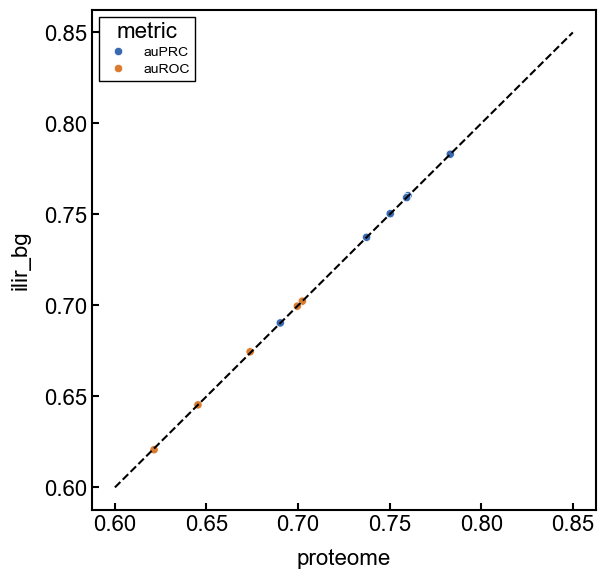

In [133]:
auc_results_df_long = auc_results_df.melt(
    id_vars=[
        "foreground",
        "background",
        "low_count_mask",
        "pseudocount",
        "data_source",
    ],
    value_vars=["auROC", "auPRC"],
    var_name="metric",
    value_name="score",
)
temp = auc_results_df_long[auc_results_df_long["data_source"] == "ilir"].copy()
# turn background into separate columns
temp = temp.pivot_table(
    index=["foreground", "low_count_mask", "pseudocount", "metric"],
    columns="background",
    values="score",
).reset_index()
fig, ax = plt.subplots()
sns.scatterplot(
    data=temp,
    x="proteome",
    y="ilir_bg",
    hue="metric",
    ax=ax,
)
ax.plot(
    [0.6, 0.85],
    [0.6, 0.85],
    linestyle="--",
    color="black",
)

# explore scores of individual sequences

In [134]:
other_scores["pssm_id"] = (
    other_scores[["foreground", "background", "low_count_mask", "pseudocount"]]
    .astype(str)
    .agg("-".join, axis=1)
)

## score distributions

(0.0, 1.0)

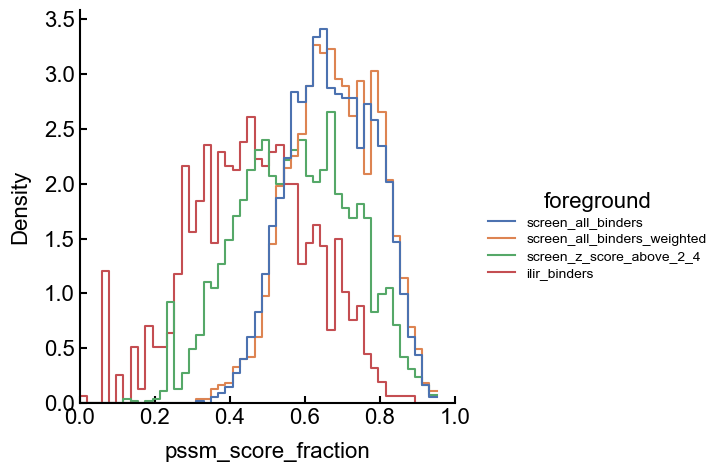

In [135]:
sns.displot(
    data=other_scores,
    x="pssm_score_fraction",
    hue="foreground",
    kind="hist",
    stat="density",
    common_norm=False,
    palette="deep",
    element="step",  # step histogram (not filled)
    fill=False,  # do not fill the histogram
)
plt.xlim(0, 1)

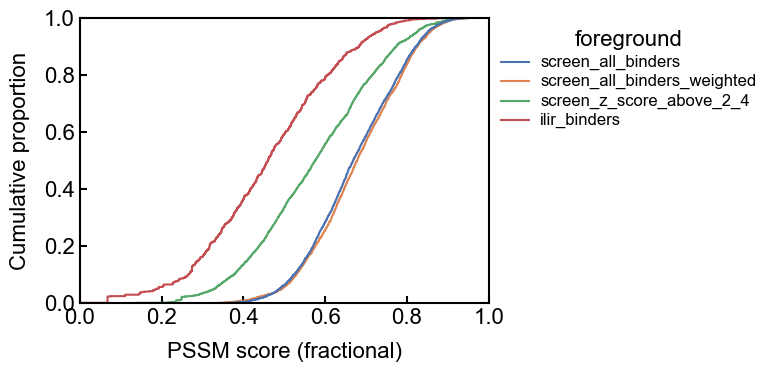

In [136]:
plt.rcParams["legend.fontsize"] = 10
fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.ecdfplot(
    data=other_scores,
    x="pssm_score_fraction",
    hue="foreground",
    stat="proportion",
    palette="deep",
    ax=ax,
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel("PSSM score (fractional)")
ax.set_ylabel("Cumulative proportion")
# put the legend outside the plot
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))  # Move legend outside plot
legend.set_frame_on(False)  # Remove legend box
plt.setp(legend.get_texts(), fontsize=12)
plt.tight_layout()

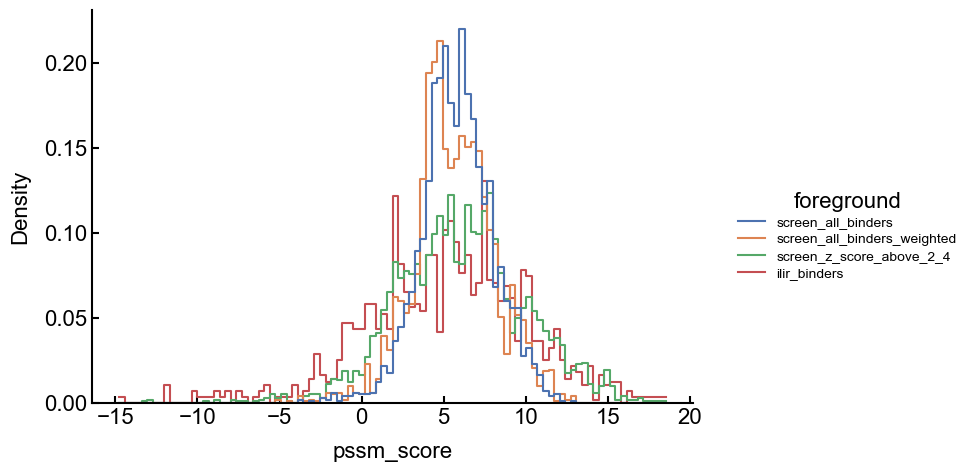

In [137]:
sns.displot(
    data=other_scores,
    x="pssm_score",
    hue="foreground",
    kind="hist",
    stat="density",
    common_norm=False,
    palette="deep",
    element="step",  # step histogram (not filled)
    fill=False,  # do not fill the histogram
    aspect=1.5,  # aspect ratio of the plot
)

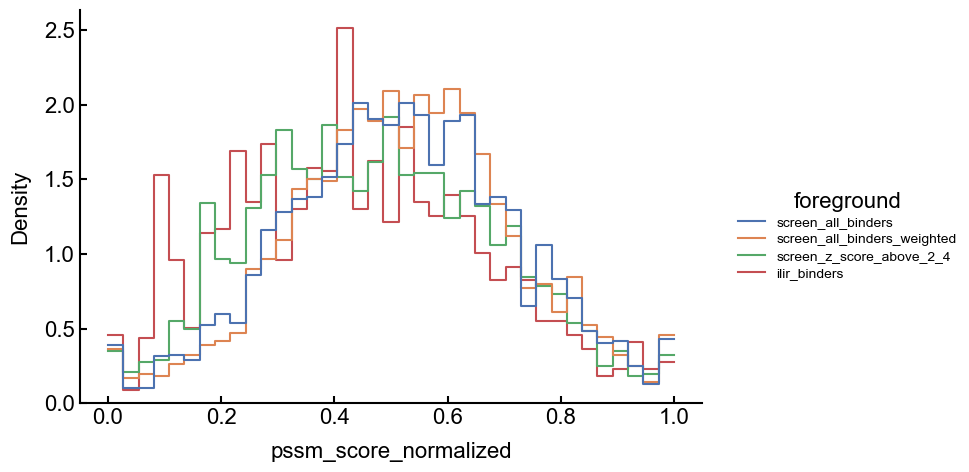

In [138]:
sns.displot(
    data=other_scores,
    x="pssm_score_normalized",
    hue="foreground",
    kind="hist",
    stat="density",
    common_norm=False,
    palette="deep",
    element="step",  # step histogram (not filled)
    fill=False,  # do not fill the histogram
    aspect=1.5,  # aspect ratio of the plot
)

In [139]:
other_scores.groupby(["foreground", "background", "low_count_mask", "pseudocount"])[
    "sequence"
].count().value_counts()

sequence
135    75
Name: count, dtype: int64

## individual sequences

In [161]:
label_map = df[["sequence", "true label"]].set_index("sequence").to_dict()["true label"]

# raw pssm scores
other_scores_pivot = other_scores.pivot(
    columns="pssm_id", index="sequence", values="pssm_score"
)
correlations = other_scores_pivot.corr(method="spearman")
other_scores_pivot["label"] = other_scores_pivot.index.map(label_map)

# fractional pssm scores
other_scores_pivot_f = other_scores.pivot(
    columns="pssm_id", index="sequence", values="pssm_score_fraction"
)
correlations_f = other_scores_pivot_f.corr(method="spearman")
other_scores_pivot_f["label"] = other_scores_pivot_f.index.map(label_map)

# normalized pssm scores
other_scores_pivot_n = other_scores.pivot(
    columns="pssm_id", index="sequence", values="pssm_score_normalized"
)
correlations_f = other_scores_pivot_n.corr(method="spearman")
other_scores_pivot_n["label"] = other_scores_pivot_n.index.map(label_map)

for i in other_scores_pivot_f.columns:
    print(i)

ilir_binders-ilir_bg-0-0.0
ilir_binders-ilir_bg-0-0.1
ilir_binders-ilir_bg-0-1.0
ilir_binders-ilir_bg-0-10.0
ilir_binders-ilir_bg-2-0.0
ilir_binders-ilir_bg-5-0.0
ilir_binders-proteome-0-0.0
ilir_binders-proteome-0-0.1
ilir_binders-proteome-0-1.0
ilir_binders-proteome-0-10.0
ilir_binders-proteome-2-0.0
ilir_binders-proteome-5-0.0
screen_all_binders-input_library-0-0.0
screen_all_binders-input_library-0-0.1
screen_all_binders-input_library-0-1.0
screen_all_binders-input_library-0-10.0
screen_all_binders-input_library-10-0.0
screen_all_binders-input_library-2-0.0
screen_all_binders-input_library-5-0.0
screen_all_binders-nonbinders_undef_pos-0-0.0
screen_all_binders-nonbinders_undef_pos-0-0.1
screen_all_binders-nonbinders_undef_pos-0-1.0
screen_all_binders-nonbinders_undef_pos-0-10.0
screen_all_binders-nonbinders_undef_pos-10-0.0
screen_all_binders-nonbinders_undef_pos-2-0.0
screen_all_binders-nonbinders_undef_pos-5-0.0
screen_all_binders-proteome-0-0.0
screen_all_binders-proteome-0-0.1
s

In [164]:
def match_regex(seq, re_pattern1, re_pattern2):
    if re.fullmatch(re_pattern1, seq):
        return re_pattern1
    elif re.fullmatch(re_pattern2, seq):
        return re_pattern2
    else:
        return np.nan

exp_f = other_scores_pivot_f.copy()
exp_f = exp_f.reset_index(names="sequence")
exp_n = other_scores_pivot_n.copy()
exp_n = exp_n.reset_index(names="sequence")

old_regex = "...[FWY]..[LVI]"
new_regex = "...[FWY]..[WFMY]"

exp_f["lir_type"] = exp_f["sequence"].apply(
    lambda x: match_regex(x, old_regex, new_regex)
)
exp_f.to_csv("./pssm_scores_pivot_fraction.csv", index=False)
exp_n["lir_type"] = exp_n["sequence"].apply(
    lambda x: match_regex(x, old_regex, new_regex)
)
exp_n.to_csv("./pssm_scores_pivot_normalized.csv", index=False)

In [142]:
exp_f

pssm_id,sequence,ilir_binders-ilir_bg-0-0.0,ilir_binders-ilir_bg-0-0.1,ilir_binders-ilir_bg-0-1.0,ilir_binders-ilir_bg-0-10.0,ilir_binders-ilir_bg-2-0.0,ilir_binders-ilir_bg-5-0.0,ilir_binders-proteome-0-0.0,ilir_binders-proteome-0-0.1,ilir_binders-proteome-0-1.0,...,screen_z_score_above_2_4-nonbinders_undef_pos-5-0.0,screen_z_score_above_2_4-proteome-0-0.0,screen_z_score_above_2_4-proteome-0-0.1,screen_z_score_above_2_4-proteome-0-1.0,screen_z_score_above_2_4-proteome-0-10.0,screen_z_score_above_2_4-proteome-10-0.0,screen_z_score_above_2_4-proteome-2-0.0,screen_z_score_above_2_4-proteome-5-0.0,label,lir_type
0,ADMYGGV,0.462178,0.578360,0.527587,0.417185,0.353579,0.234050,0.462278,0.578443,0.527760,...,0.431691,0.394752,0.690592,0.581943,0.471089,0.339193,0.460222,0.408368,0,...[FWY]..[LVI]
1,AESFEVL,0.461811,0.736762,0.588562,0.301955,0.411768,0.264824,0.461487,0.736555,0.588292,...,0.691009,0.702285,0.846070,0.775755,0.577771,0.601491,0.655319,0.668720,0,...[FWY]..[LVI]
2,ANSFTLI,0.431897,0.658861,0.557036,0.357174,0.369857,0.227828,0.431391,0.658658,0.556746,...,0.482963,0.587580,0.786749,0.689983,0.495083,0.432545,0.522520,0.507398,1,...[FWY]..[LVI]
3,APPYDSL,0.309712,0.585849,0.461350,0.293433,0.294226,0.159604,0.309515,0.585701,0.461169,...,0.428863,0.455797,0.719392,0.600533,0.422749,0.348010,0.369947,0.421626,0,...[FWY]..[LVI]
4,ASDWIGI,0.659510,0.754127,0.708910,0.510563,0.623018,0.455893,0.659329,0.754047,0.708799,...,0.521758,0.477150,0.732292,0.636070,0.531607,0.438675,0.506262,0.515576,1,...[FWY]..[LVI]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,VHVYGAY,0.243833,0.441179,0.402507,0.383628,0.170922,0.000000,0.243998,0.441283,0.402711,...,0.247569,0.359373,0.670839,0.542400,0.425474,0.129315,0.373485,0.220175,0,...[FWY]..[WFMY]
131,VTNWGRI,0.541799,0.480684,0.520940,0.478055,0.442321,0.317354,0.541766,0.480688,0.520922,...,0.511652,0.541268,0.764702,0.676290,0.570937,0.332937,0.571954,0.517277,1,...[FWY]..[LVI]
132,WMFWAML,0.552732,0.551525,0.643435,0.652330,0.460698,0.274288,0.552619,0.551638,0.643574,...,0.471685,0.583305,0.720374,0.699074,0.745601,0.359607,0.595441,0.459820,1,...[FWY]..[LVI]
133,YHNYQTL,0.348108,0.507705,0.497968,0.458468,0.241587,0.068000,0.347761,0.507622,0.497830,...,0.396363,0.609934,0.711996,0.661567,0.591033,0.249031,0.546955,0.407840,0,...[FWY]..[LVI]


### correlation of pssm scores

<Axes: xlabel='pssm_id', ylabel='pssm_id'>

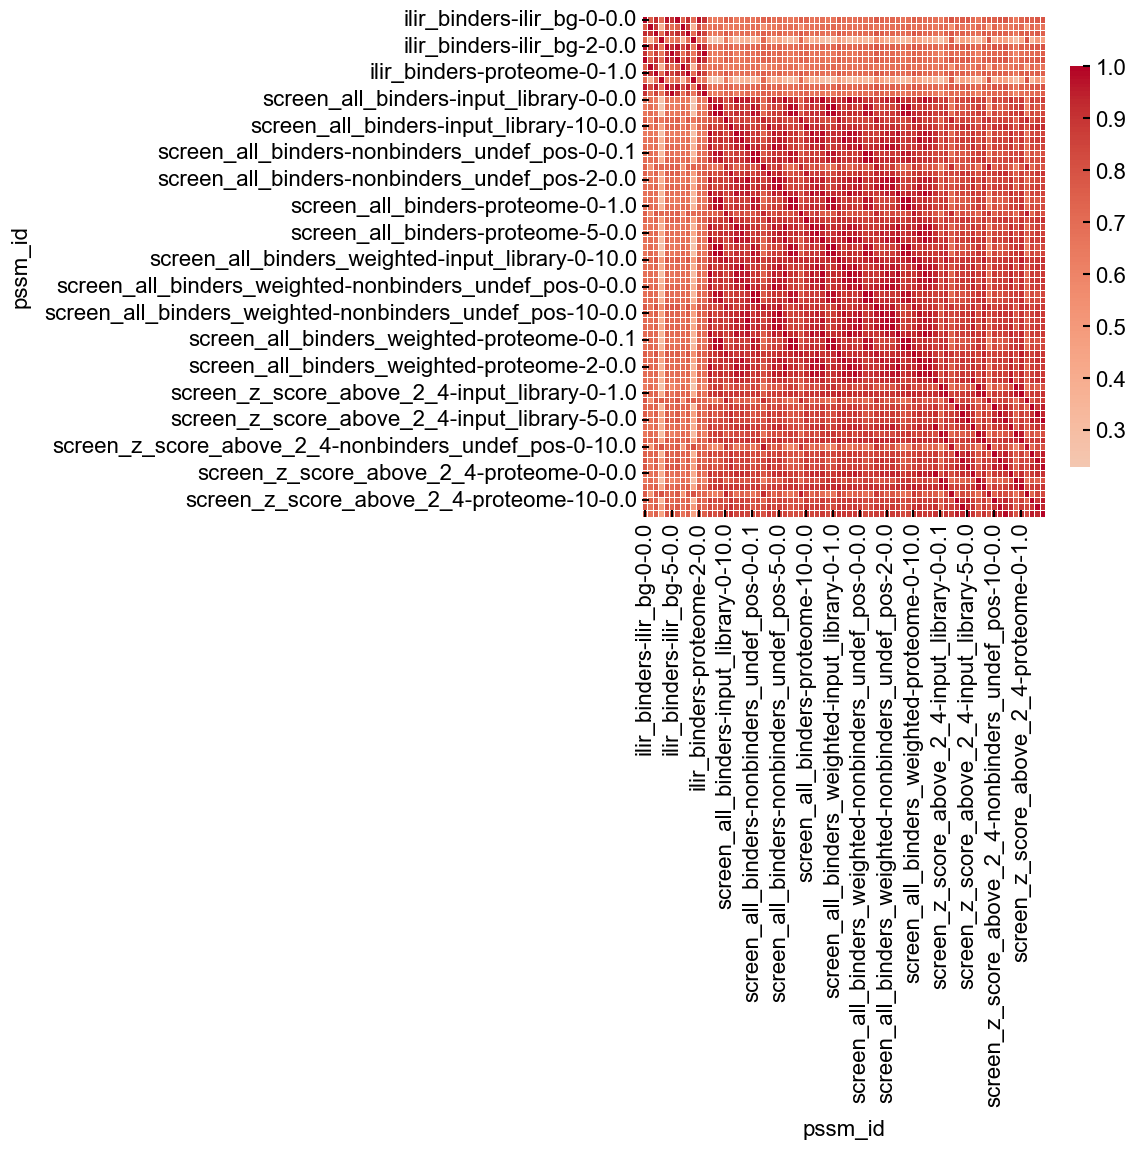

In [143]:
sns.heatmap(
    correlations_f,
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": .8},
)

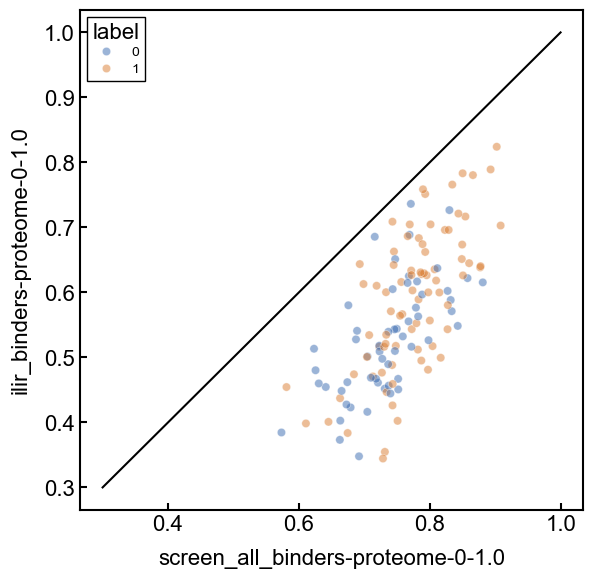

In [144]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=other_scores_pivot_f,
    x="screen_all_binders-proteome-0-1.0",
    y="ilir_binders-proteome-0-1.0",
    alpha=0.5,
    hue="label",
    ax=ax,
)
ax.plot(
    np.linspace(0.3, 1, 100),
    np.linspace(0.3, 1, 100),
    linestyle="-",
    color="black",
)

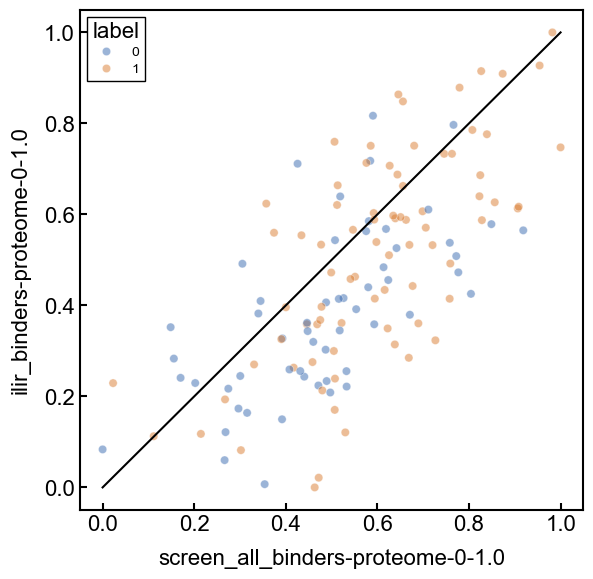

In [166]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=other_scores_pivot_n,
    x="screen_all_binders-proteome-0-1.0",
    y="ilir_binders-proteome-0-1.0",
    alpha=0.5,
    hue="label",
    ax=ax,
)
ax.plot(
    np.linspace(0, 1, 100),
    np.linspace(0, 1, 100),
    linestyle="-",
    color="black",
)

<Axes: >

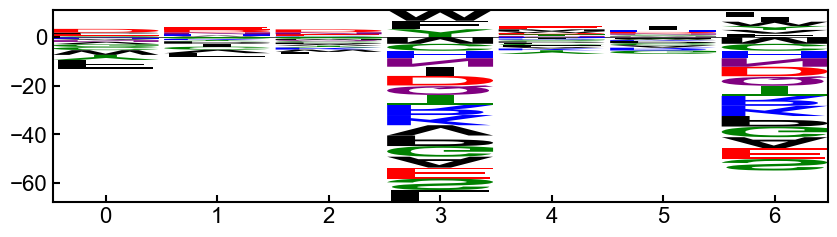

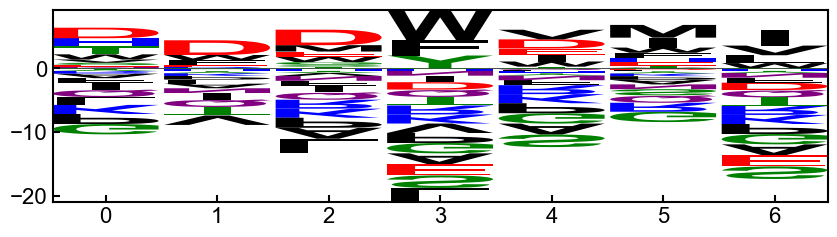

In [145]:
columns2compare = ["screen_all_binders-proteome-0-1.0", "ilir_binders-proteome-0-1.0"]
pssms.plot_logo(pssms_dict[columns2compare[0]])
pssms.plot_logo(pssms_dict[columns2compare[1]])

In [146]:
pssms_dict.keys()

dict_keys(['screen_all_binders-proteome-0-0.0', 'screen_all_binders-proteome-2-0.0', 'screen_all_binders-proteome-5-0.0', 'screen_all_binders-proteome-10-0.0', 'screen_all_binders-proteome-0-0.1', 'screen_all_binders-proteome-0-1.0', 'screen_all_binders-proteome-0-10.0', 'screen_all_binders-input_library-0-0.0', 'screen_all_binders-input_library-2-0.0', 'screen_all_binders-input_library-5-0.0', 'screen_all_binders-input_library-10-0.0', 'screen_all_binders-input_library-0-0.1', 'screen_all_binders-input_library-0-1.0', 'screen_all_binders-input_library-0-10.0', 'screen_all_binders-nonbinders_undef_pos-0-0.0', 'screen_all_binders-nonbinders_undef_pos-2-0.0', 'screen_all_binders-nonbinders_undef_pos-5-0.0', 'screen_all_binders-nonbinders_undef_pos-10-0.0', 'screen_all_binders-nonbinders_undef_pos-0-0.1', 'screen_all_binders-nonbinders_undef_pos-0-1.0', 'screen_all_binders-nonbinders_undef_pos-0-10.0', 'screen_all_binders_weighted-proteome-0-0.0', 'screen_all_binders_weighted-proteome-2-0

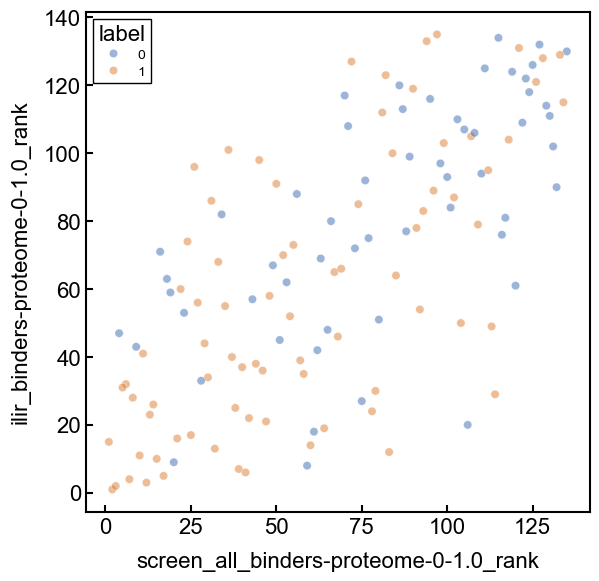

In [170]:

temp = other_scores_pivot_f.copy()
temp = temp[columns2compare + ["label"]]
for i in columns2compare:
    temp[f"{i}_rank"] = temp[i].rank(ascending=False, method="min")

fig, ax = plt.subplots()
sns.scatterplot(
    data=temp,
    x=columns2compare[0] + "_rank",
    y=columns2compare[1] + "_rank",
    alpha=0.5,
    hue="label",
    ax=ax,
)
temp = temp.reset_index(names="sequence")
temp2 = temp.copy().melt(
    id_vars=["sequence", "label"],
    value_vars=columns2compare,
    var_name="pssm_id",
    value_name="score",
)

<Axes: xlabel='pssm_id', ylabel='score'>

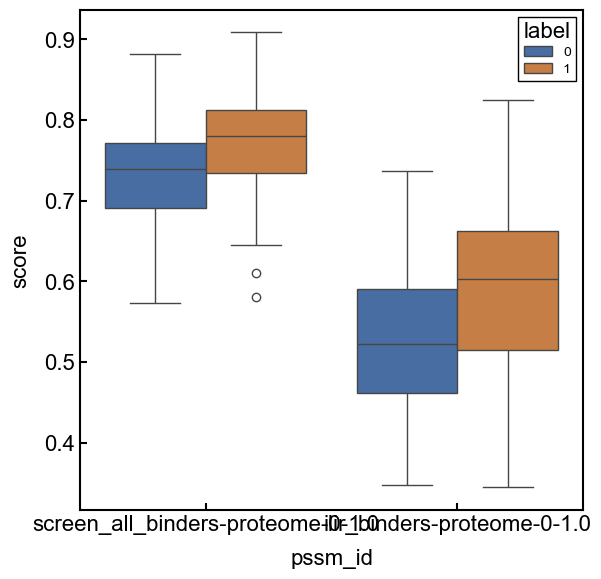

In [148]:
sns.boxplot(
    data=temp2,
    x="pssm_id",
    y="score",
    hue="label",
)

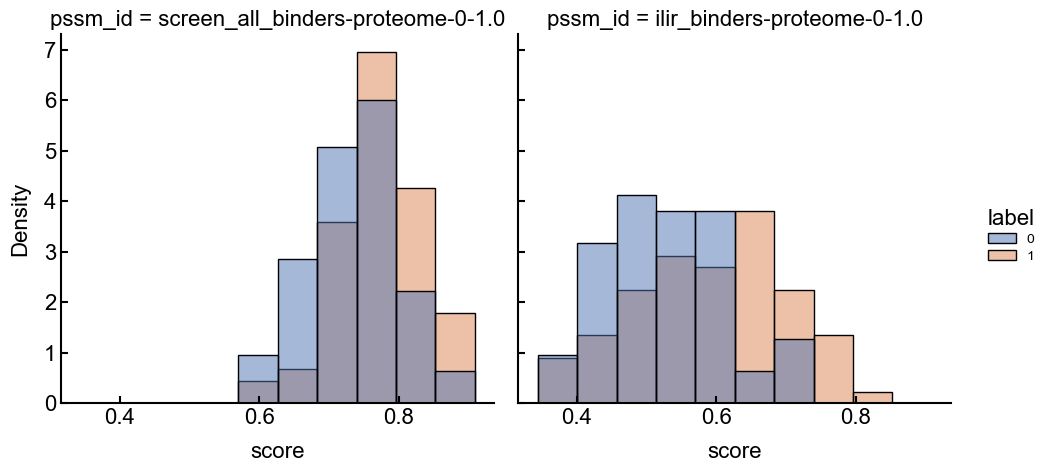

In [149]:
sns.displot(
    data=temp2,
    x="score",
    hue="label",
    col="pssm_id",
    kind="hist",
    common_norm=False,
    stat="density",
    fill=True,
    palette="deep",
)

## split sequences into "old" and "new" lirs

In [172]:
temp_n = other_scores_pivot_n.copy()
temp_n = temp_n[columns2compare + ["label"]]
temp_n = temp_n.reset_index(names="sequence")
temp_n_long = temp_n.copy().melt(
    id_vars=["sequence", "label"],
    value_vars=columns2compare,
    var_name="pssm_id",
    value_name="score",
)

In [173]:
old_regex = "...[FWY]..[LVI]"
new_regex = "...[FWY]..[WFMY]"


def match_regex(seq, re_pattern1, re_pattern2):
    if re.fullmatch(re_pattern1, seq):
        return re_pattern1
    elif re.fullmatch(re_pattern2, seq):
        return re_pattern2
    else:
        return np.nan


temp_n_long["lir_type"] = temp_n_long["sequence"].apply(
    lambda x: match_regex(x, old_regex, new_regex)
)
temp_n["lir_type"] = temp_n["sequence"].apply(
    lambda x: match_regex(x, old_regex, new_regex)
)

<Axes: xlabel='lir_type', ylabel='score'>

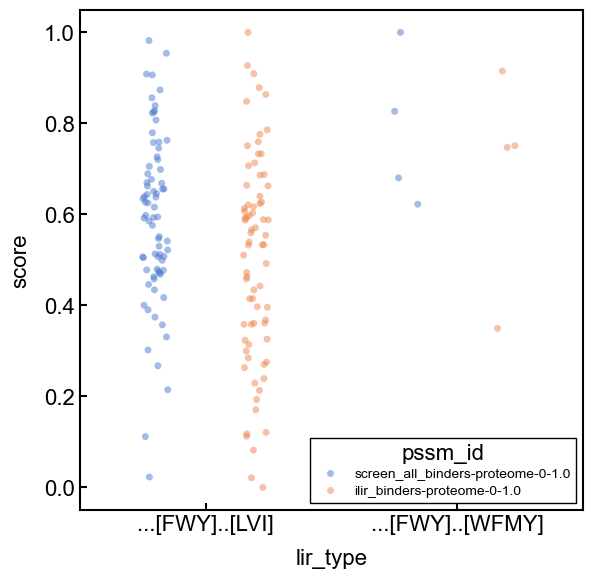

In [175]:
sns.stripplot(
    data=temp_n_long[temp_n_long["label"] == 1],
    x="lir_type",
    y="score",
    hue="pssm_id",
    alpha=0.5,
    jitter=True,
    palette="muted",
    dodge=True,
)

([0, 1],
 [Text(0, 0, 'screen_all_binders-proteome-0-1.0'),
  Text(1, 0, 'ilir_binders-proteome-0-1.0')])

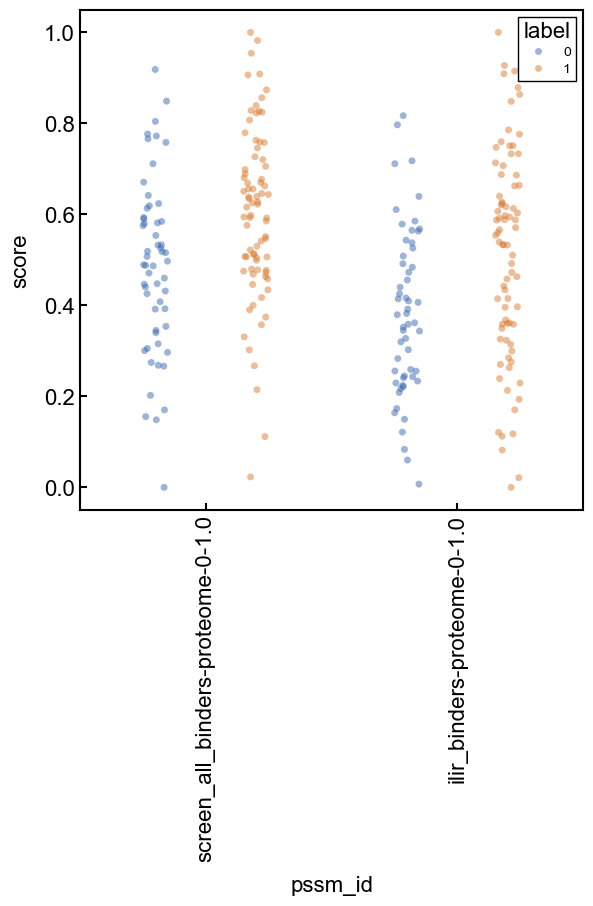

In [176]:
sns.stripplot(
    data=temp_n_long,
    x="pssm_id",
    y="score",
    hue="label",
    alpha=0.5,
    jitter=True,
    dodge=True,
)
# rotate x-axis labels
plt.xticks(rotation=90)

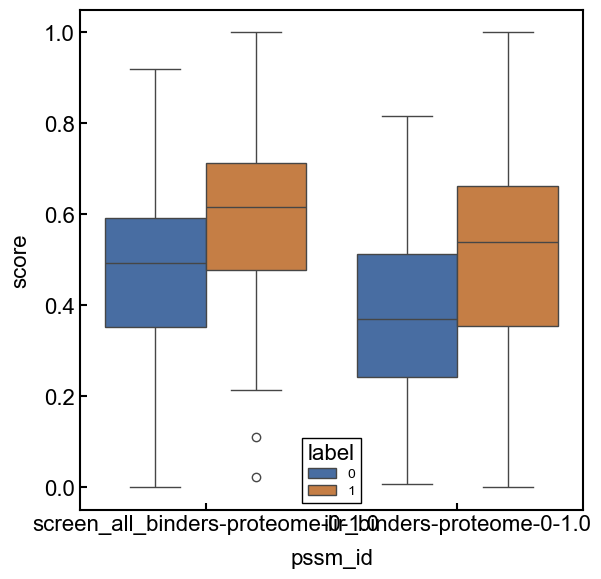

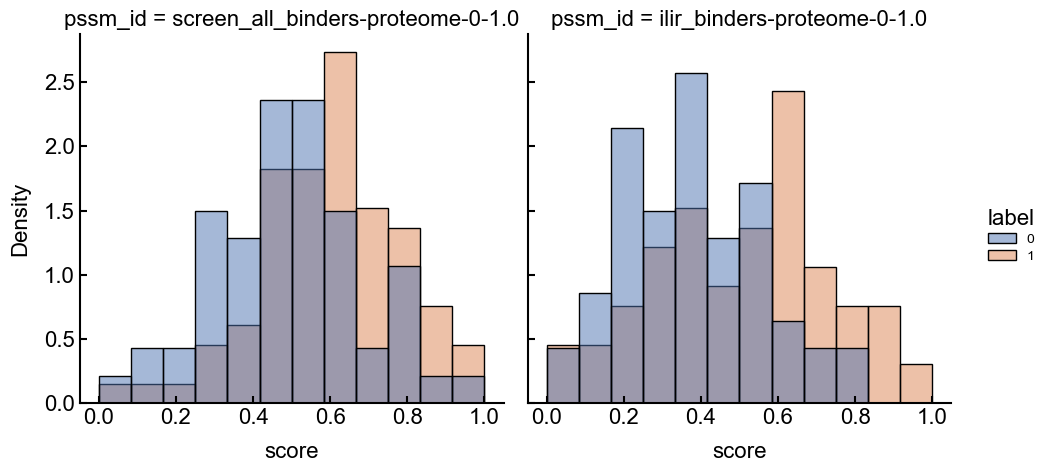

In [177]:
sns.boxplot(
    data=temp_n_long,
    x="pssm_id",
    y="score",
    hue="label",
)
sns.displot(
    data=temp_n_long,
    x="score",
    hue="label",
    col="pssm_id",
    kind="hist",
    common_norm=False,
    stat="density",
    fill=True,
    palette="deep",
)

In [153]:
temp

pssm_id,sequence,screen_all_binders-proteome-0-1.0,ilir_binders-proteome-0-1.0,label,screen_all_binders-proteome-0-1.0_rank,ilir_binders-proteome-0-1.0_rank,lir_type
0,ADMYGGV,0.687287,0.527760,0,117.0,81.0,...[FWY]..[LVI]
1,AESFEVL,0.832066,0.588292,0,19.0,59.0,...[FWY]..[LVI]
2,ANSFTLI,0.800169,0.556746,1,33.0,68.0,...[FWY]..[LVI]
3,APPYDSL,0.720878,0.461169,0,103.0,110.0,...[FWY]..[LVI]
4,ASDWIGI,0.743009,0.708799,1,83.0,12.0,...[FWY]..[LVI]
...,...,...,...,...,...,...,...
130,VHVYGAY,0.663285,0.402711,0,125.0,126.0,...[FWY]..[WFMY]
131,VTNWGRI,0.732562,0.520922,1,93.0,83.0,...[FWY]..[LVI]
132,WMFWAML,0.693084,0.643574,1,114.0,29.0,...[FWY]..[LVI]
133,YHNYQTL,0.727459,0.497830,0,98.0,97.0,...[FWY]..[LVI]


In [154]:
import altair as alt
from vega_datasets import data
import pandas as pd

temp_long = pd.melt(
    temp,
    id_vars=["sequence", "label"],
    value_vars=[i + "_rank" for i in columns2compare],
    var_name="PSSM",
    value_name="Rank",
)
chart = (
    alt.Chart(temp_long)
    .mark_line(point=True)
    .encode(
        x=alt.X("PSSM:N", title=None),
        y=alt.Y("Rank:O", sort="ascending", title="Rank"),
        color="sequence:N",
        detail="sequence:N",
    )
    .properties(
        title="Bump Chart: Sequence Rankings by Two Scores", width=800, height=900
    )
)
chart

alt.Chart(...)

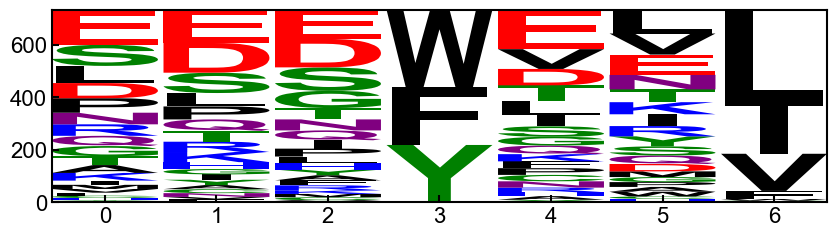

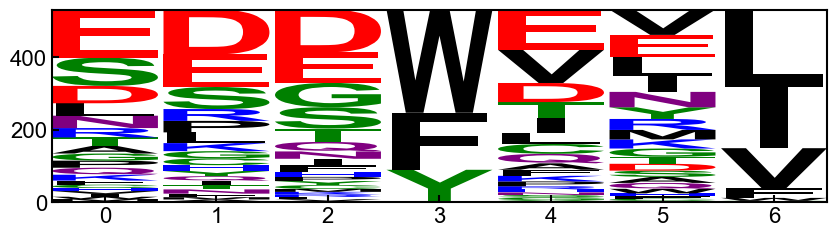

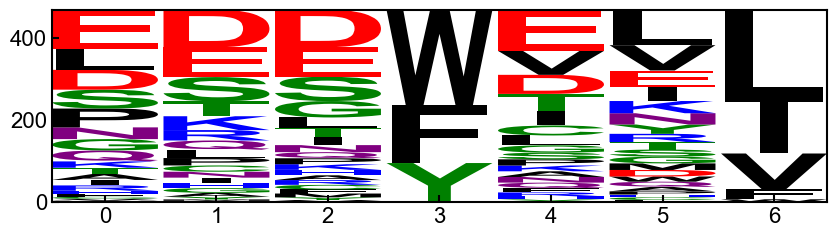

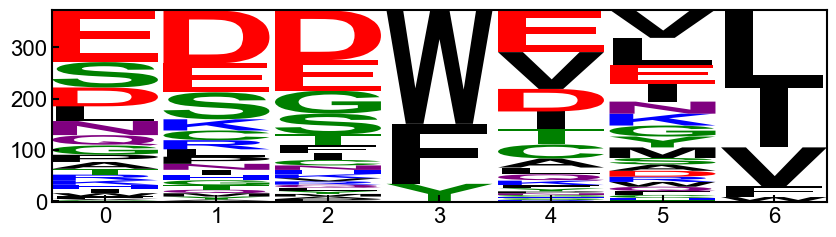

In [167]:
temp3 = other_scores_pivot.copy()
temp3 = temp3[columns2compare + ["label"]].reset_index(names="sequence")


temp3[['sequence', 'screen_all_binders-proteome-0-1.0']].values[:,0]

def pssm_weighted_logo(
    df: pd.DataFrame,
    score_column: str,
):
    x = df[['sequence', score_column]].values
    c = pssms.seqlist_2_counts_matrix(x[:, 0], x[:, 1])
    pssms.plot_logo(c)



pssm_weighted_logo(temp3, "screen_all_binders-proteome-0-1.0")
pssm_weighted_logo(temp3, "ilir_binders-proteome-0-1.0")

pssm_weighted_logo(temp3[temp3['label']==1], "screen_all_binders-proteome-0-1.0")
pssm_weighted_logo(temp3[temp3['label']==1], "ilir_binders-proteome-0-1.0")

In [156]:
temp3

pssm_id,sequence,screen_all_binders-proteome-0-1.0,ilir_binders-proteome-0-1.0,label
0,ADMYGGV,3.176826,2.847177,0
1,AESFEVL,7.761730,4.680725,0
2,ANSFTLI,6.751610,3.725185,1
3,APPYDSL,4.240609,0.830123,0
4,ASDWIGI,4.941466,8.330905,1
...,...,...,...,...
130,VHVYGAY,2.416737,-0.940588,0
131,VTNWGRI,4.610617,2.640061,1
132,WMFWAML,3.360430,6.355223,1
133,YHNYQTL,4.449025,1.940613,0


/Users/jackson/mambaforge/envs/lir_proteome_screen_pssm/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jackson/mambaforge/envs/lir_proteome_screen_pssm/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


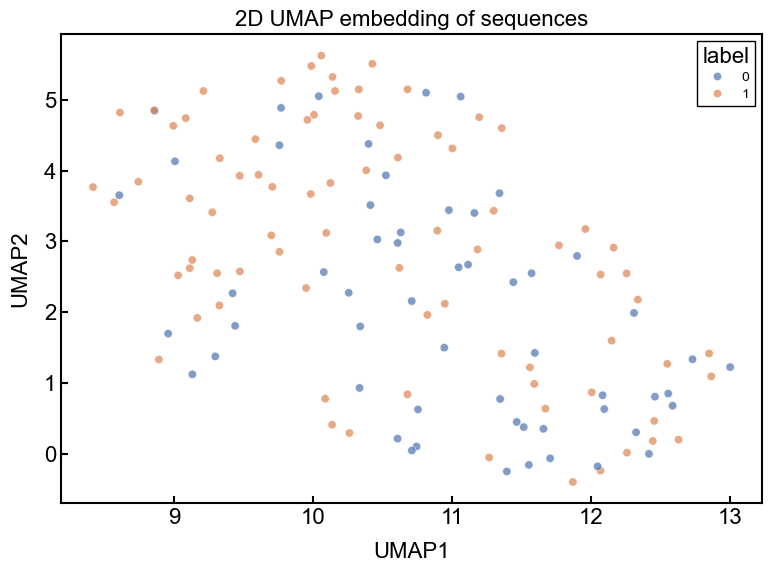

In [168]:
# Example: 2D embedding of sequences using UMAP on one-hot encoded sequences

# Prepare sequences for embedding
seqs = other_scores_pivot_f.index.tolist()
# One-hot encode sequences (assuming all are same length)
encoder = OneHotEncoder(sparse_output=False)
X = encoder.fit_transform(np.array([list(s) for s in seqs]))

# Compute 2D UMAP embedding
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# Add embedding to DataFrame
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"], index=seqs)
embedding_df["label"] = other_scores_pivot_f["label"]

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=embedding_df, x="UMAP1", y="UMAP2", hue="label", alpha=0.7, palette="deep"
)
plt.title("2D UMAP embedding of sequences")
plt.tight_layout()
plt.show()

In [169]:
fractional_score("".join(pssm.idxmax(axis=1).values), pssm)
fractional_score("".join(pssm.idxmin(axis=1).values), pssm)


pssm.idxmin(axis=1)

0    W
1    C
2    F
3    D
4    W
5    G
6    N
dtype: object

In [159]:
embedding_df

,UMAP1,UMAP2,label
ADMYGGV,10.756959,0.623844,0
AESFEVL,10.079095,2.565182,0
ANSFTLI,9.951223,2.340067,1
APPYDSL,12.086020,0.824478,0
ASDWIGI,8.995862,4.632595,1
...,...,...,...
VHVYGAY,10.746684,0.100635,0
VTNWGRI,8.611366,4.820058,1
WMFWAML,10.160135,5.125397,1
YHNYQTL,10.712566,0.044022,0
